# RPS Performance Analysis

This notebook analyzes the performance results from the Rashomon Partition Set (RPS) algorithm simulation study. 

The simulation varies:
- **M**: Number of features (3, 4, 5)
- **R**: Factor levels per feature (3, 4, 5) 
- **H**: Maximum number of pools (multipliers: 1.0, 1.5, 2.0)
- **ε (epsilon)**: Rashomon threshold (0.5, 1.0, 2.0, 4.0)

For each parameter combination, we analyze:
- **Runtime performance** of the RPS algorithm
- **Accuracy** in terms of pool mean errors
- **Coverage** comparing RPS partitions found vs. total possible partitions

## 1. Import Required Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12


## 2. Load the Results Data

In [12]:
# Load the simulation results
try:
    df = pd.read_csv("../Results/timed_sims/rps_performance_results.csv")
    print(f"✅ Successfully loaded {len(df)} simulation results")
    print(f"📊 Data shape: {df.shape}")
except FileNotFoundError:
    print("❌ Results file not found. Please run the simulation first:")
    print("   python rps_performance_simulation.py")
    df = None

if df is not None:
    # Add derived columns for analysis
    df['complexity'] = df['R_val'] ** df['M']
    # df['H_relative'] = df['H'] / (df['M'] * df['R_val'])  # H relative to problem size
    df['coverage_ratio'] = df['num_rps_partitions'] / df['total_partitions']
    df['log_rps_time'] = np.log10(df['rps_time'] + 1e-6)  # Log transform for better visualization
    
    print("📈 Added derived columns: complexity, H_relative, coverage_ratio, log_rps_time")

✅ Successfully loaded 10 simulation results
📊 Data shape: (10, 17)
📈 Added derived columns: complexity, H_relative, coverage_ratio, log_rps_time


## 3. Explore Data Structure

In [9]:
if df is not None:
    print("=== DATA OVERVIEW ===")
    print(f"Shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    
    print("\n=== FIRST FEW ROWS ===")
    display(df.head())
    
    print("\n=== DATA TYPES ===")
    display(df.dtypes)
    
    print("\n=== PARAMETER RANGES ===")
    param_summary = df[['M', 'R_val', 'epsilon']].describe()
    display(param_summary)
    
    print("\n=== UNIQUE PARAMETER COMBINATIONS ===")
    unique_combinations = df.groupby(['M', 'R_val', 'epsilon']).size().reset_index(name='count')
    print(f"Total parameter combinations: {len(unique_combinations)}")
    print(f"Simulations per combination: {unique_combinations['count'].describe()}")
    
    print("\n=== MISSING VALUES ===")
    missing_summary = df.isnull().sum()
    if missing_summary.sum() > 0:
        display(missing_summary[missing_summary > 0])
    else:
        print("✅ No missing values found")

=== DATA OVERVIEW ===
Shape: (10, 20)
Columns: ['M', 'R_val', 'epsilon', 'seed', 'n_per_policy', 'all_partitions_time', 'rps_time', 'total_partitions', 'num_rps_partitions', 'map_q_value', 'map_posterior_prob', 'norm_constant', 'rps_norm_constant', 'theta_used', 'found_true_partition', 'rps_posterior_beta_error', 'full_posterior_beta_error', 'complexity', 'coverage_ratio', 'log_rps_time']

=== FIRST FEW ROWS ===


,M,R_val,epsilon,seed,n_per_policy,all_partitions_time,rps_time,total_partitions,num_rps_partitions,map_q_value,map_posterior_prob,norm_constant,rps_norm_constant,theta_used,found_true_partition,rps_posterior_beta_error,full_posterior_beta_error,complexity,coverage_ratio,log_rps_time
0,3,4,0.1,0,30,0.073275,0.170125,64,2,1.48257,0.029305,1.0,0.427308,1.630827,0,2.357562,2.741462,12,0.031250,-0.769229
1,3,4,0.2,0,30,0.073275,0.181923,64,9,1.48257,0.029305,1.0,1.673319,1.779084,1,2.248912,2.741462,12,0.140625,-0.740110
2,3,4,0.3,0,30,0.073275,0.172749,64,20,1.48257,0.029305,1.0,3.355312,1.927340,1,2.724653,2.741462,12,0.312500,-0.762582
3,3,4,0.4,0,30,0.073275,0.184611,64,30,1.48257,0.029305,1.0,4.696028,2.075597,1,2.877881,2.741462,12,0.468750,-0.733740
4,3,4,0.5,0,30,0.073275,0.199485,64,42,1.48257,0.029305,1.0,6.081030,2.223854,1,2.838337,2.741462,12,0.656250,-0.700088



=== DATA TYPES ===


M                              int64
R_val                          int64
epsilon                      float64
seed                           int64
n_per_policy                   int64
all_partitions_time          float64
rps_time                     float64
total_partitions               int64
num_rps_partitions             int64
map_q_value                  float64
map_posterior_prob           float64
norm_constant                float64
rps_norm_constant            float64
theta_used                   float64
found_true_partition           int64
rps_posterior_beta_error     float64
full_posterior_beta_error    float64
complexity                     int64
coverage_ratio               float64
log_rps_time                 float64
dtype: object


=== PARAMETER RANGES ===


,M,R_val,epsilon
count,10.0,10.0,10.000000
mean,3.0,4.0,0.550000
std,0.0,0.0,0.302765
min,3.0,4.0,0.100000
25%,3.0,4.0,0.325000
50%,3.0,4.0,0.550000
75%,3.0,4.0,0.775000
max,3.0,4.0,1.000000



=== UNIQUE PARAMETER COMBINATIONS ===
Total parameter combinations: 10
Simulations per combination: count    10.0
mean      1.0
std       0.0
min       1.0
25%       1.0
50%       1.0
75%       1.0
max       1.0
Name: count, dtype: float64

=== MISSING VALUES ===
✅ No missing values found


## 4. Performance Statistical Analysis

In [13]:
if df is not None:
    print("=== RUNTIME PERFORMANCE ANALYSIS ===")
    
    # Overall timing statistics
    timing_stats = df['rps_time'].describe()
    print("📊 Overall Runtime Statistics:")
    display(timing_stats)
    
    # Timing by complexity
    print("\n📈 Runtime by Problem Complexity (R^M):")
    timing_by_complexity = df.groupby('complexity')['rps_time'].agg(['count', 'mean', 'std', 'min', 'max'])
    display(timing_by_complexity)
    
    # Timing by individual parameters
    print("\n🔍 Runtime by M (Number of Features):")
    timing_by_M = df.groupby('M')['rps_time'].agg(['mean', 'std'])
    display(timing_by_M)
    
    print("\n🔍 Runtime by R (Factor Levels):")
    timing_by_R = df.groupby('R_val')['rps_time'].agg(['mean', 'std'])
    display(timing_by_R)
    
    # print("\n🔍 Runtime by H (Max Pools):")
    # timing_by_H = df.groupby('H')['rps_time'].agg(['mean', 'std'])
    # display(timing_by_H)
    
    print("\n🔍 Runtime by Epsilon (Rashomon Threshold):")
    timing_by_epsilon = df.groupby('epsilon')['rps_time'].agg(['mean', 'std'])
    display(timing_by_epsilon)

=== RUNTIME PERFORMANCE ANALYSIS ===
📊 Overall Runtime Statistics:


count    10.000000
mean      0.193420
std       0.014817
min       0.170125
25%       0.182595
50%       0.200519
75%       0.202135
max       0.211173
Name: rps_time, dtype: float64


📈 Runtime by Problem Complexity (R^M):


,count,mean,std,min,max
complexity,,,,,
64,10,0.19342,0.014817,0.170125,0.211173



🔍 Runtime by M (Number of Features):


,mean,std
M,,
3,0.19342,0.014817



🔍 Runtime by R (Factor Levels):


,mean,std
R_val,,
4,0.19342,0.014817



🔍 Runtime by Epsilon (Rashomon Threshold):


,mean,std
epsilon,,
0.1,0.170125,NaN
0.2,0.181923,NaN
0.3,0.172749,NaN
0.4,0.184611,NaN
0.5,0.199485,NaN
0.6,0.201554,NaN
0.7,0.201625,NaN
0.8,0.202305,NaN
0.9,0.211173,NaN


In [17]:
if df is not None:
    print("=== ACCURACY ANALYSIS ===")
    
    # Pool mean error statistics
    error_stats = df['rps_posterior_beta_error'].describe()
    print("📊 RPS Posterior Error Statistics:")
    display(error_stats)
    
    # Error by epsilon (Rashomon threshold)
    print("\n🎯 Error by Epsilon (Rashomon Threshold):")
    error_by_epsilon = df.groupby('epsilon')['rps_posterior_beta_error'].agg(['count', 'mean', 'std', 'min', 'max'])
    display(error_by_epsilon)
    
    # Error by complexity
    print("\n📈 Error by Problem Complexity:")
    error_by_complexity = df.groupby('complexity')['rps_posterior_beta_error'].agg(['mean', 'std'])
    display(error_by_complexity)
    
    # Coverage analysis
    print("\n=== COVERAGE ANALYSIS ===")
    coverage_stats = df['coverage_ratio'].describe()
    print("📊 Coverage Ratio Statistics (RPS found / Total possible):")
    display(coverage_stats)
    
    print("\n🎯 Coverage by Epsilon:")
    coverage_by_epsilon = df.groupby('epsilon')['coverage_ratio'].agg(['mean', 'std'])
    display(coverage_by_epsilon)
    
    # Partition count analysis
    print("\n=== PARTITION COUNT ANALYSIS ===")
    print("📊 RPS Partitions Found:")
    rps_partition_stats = df['num_rps_partitions'].describe()
    display(rps_partition_stats)
    
    print("\n📊 Total Possible Partitions:")
    total_partition_stats = df['total_partitions'].describe()
    display(total_partition_stats)

=== ACCURACY ANALYSIS ===
📊 RPS Posterior Error Statistics:


count    10.000000
mean      2.700916
std       0.215704
min       2.248912
25%       2.731583
50%       2.782670
75%       2.822108
max       2.877881
Name: rps_posterior_beta_error, dtype: float64


🎯 Error by Epsilon (Rashomon Threshold):


,count,mean,std,min,max
epsilon,,,,,
0.1,1,2.357562,NaN,2.357562,2.357562
0.2,1,2.248912,NaN,2.248912,2.248912
0.3,1,2.724653,NaN,2.724653,2.724653
0.4,1,2.877881,NaN,2.877881,2.877881
0.5,1,2.838337,NaN,2.838337,2.838337
0.6,1,2.797285,NaN,2.797285,2.797285
0.7,1,2.821940,NaN,2.821940,2.821940
0.8,1,2.822164,NaN,2.822164,2.822164
0.9,1,2.768056,NaN,2.768056,2.768056



📈 Error by Problem Complexity:


,mean,std
complexity,,
64,2.700916,0.215704



=== COVERAGE ANALYSIS ===
📊 Coverage Ratio Statistics (RPS found / Total possible):


count    10.000000
mean      0.590625
std       0.334292
min       0.031250
25%       0.351562
50%       0.695312
75%       0.847656
max       0.953125
Name: coverage_ratio, dtype: float64


🎯 Coverage by Epsilon:


,mean,std
epsilon,,
0.1,0.031250,NaN
0.2,0.140625,NaN
0.3,0.312500,NaN
0.4,0.468750,NaN
0.5,0.656250,NaN
0.6,0.734375,NaN
0.7,0.812500,NaN
0.8,0.859375,NaN
0.9,0.937500,NaN



=== PARTITION COUNT ANALYSIS ===
📊 RPS Partitions Found:


count    10.000000
mean     37.800000
std      21.394703
min       2.000000
25%      22.500000
50%      44.500000
75%      54.250000
max      61.000000
Name: num_rps_partitions, dtype: float64


📊 Total Possible Partitions:


count    10.0
mean     64.0
std       0.0
min      64.0
25%      64.0
50%      64.0
75%      64.0
max      64.0
Name: total_partitions, dtype: float64

## 5. Visualize Results

### 5.1 Runtime Performance Visualization

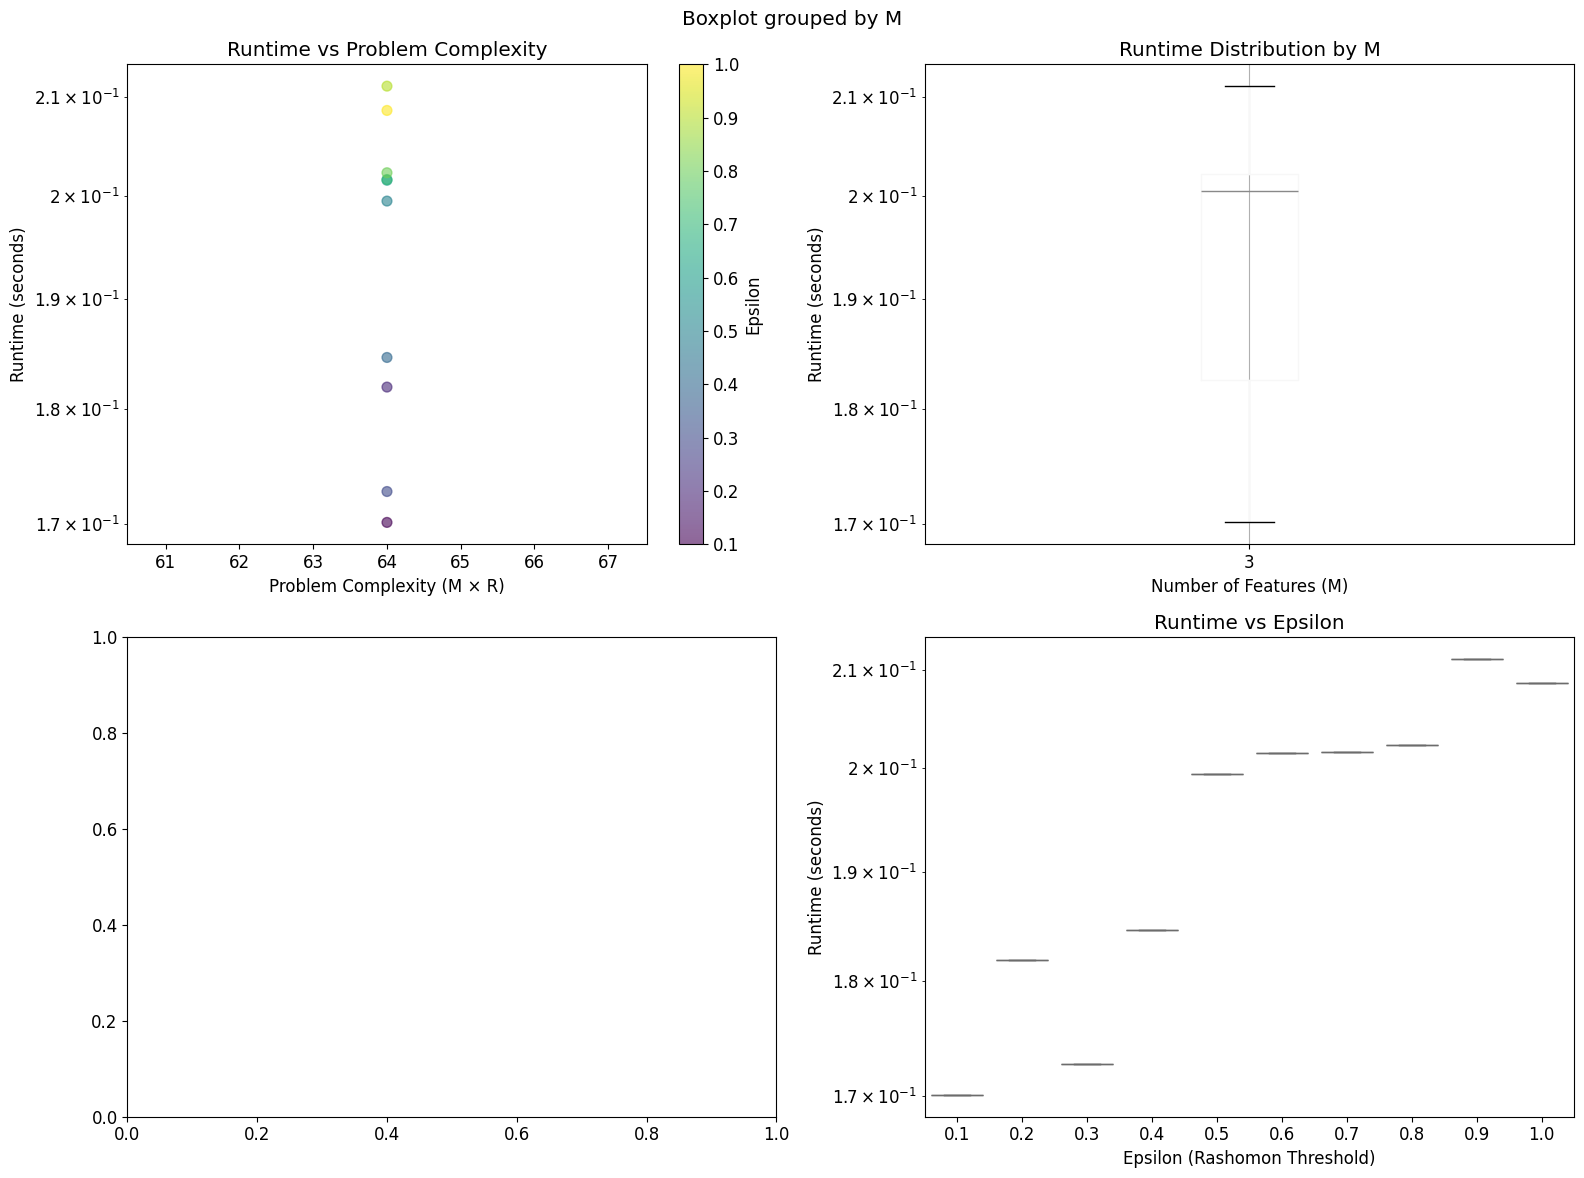

In [18]:
if df is not None:
    # Create a 2x2 subplot for runtime analysis
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('RPS Algorithm Runtime Performance Analysis', fontsize=16, fontweight='bold')
    
    # 1. Runtime vs Complexity
    ax1 = axes[0, 0]
    scatter = ax1.scatter(df['complexity'], df['rps_time'], 
                         c=df['epsilon'], cmap='viridis', alpha=0.6, s=50)
    ax1.set_xlabel('Problem Complexity (M × R)')
    ax1.set_ylabel('Runtime (seconds)')
    ax1.set_title('Runtime vs Problem Complexity')
    ax1.set_yscale('log')
    plt.colorbar(scatter, ax=ax1, label='Epsilon')
    
    # 2. Runtime distribution by M
    ax2 = axes[0, 1]
    df.boxplot(column='rps_time', by='M', ax=ax2)
    ax2.set_xlabel('Number of Features (M)')
    ax2.set_ylabel('Runtime (seconds)')
    ax2.set_title('Runtime Distribution by M')
    ax2.set_yscale('log')
    
    # # 3. Runtime vs H (max pools)
    # ax3 = axes[1, 0]
    # sns.scatterplot(data=df, x='H', y='rps_time', hue='epsilon', ax=ax3)
    # ax3.set_xlabel('Maximum Pools (H)')
    # ax3.set_ylabel('Runtime (seconds)')
    # ax3.set_title('Runtime vs Maximum Pools')
    # ax3.set_yscale('log')
    
    # 4. Runtime vs Epsilon
    ax4 = axes[1, 1]
    sns.boxplot(data=df, x='epsilon', y='rps_time', ax=ax4)
    ax4.set_xlabel('Epsilon (Rashomon Threshold)')
    ax4.set_ylabel('Runtime (seconds)')
    ax4.set_title('Runtime vs Epsilon')
    ax4.set_yscale('log')
    
    plt.tight_layout()
    plt.show()

### 5.2 Accuracy and Coverage Visualization

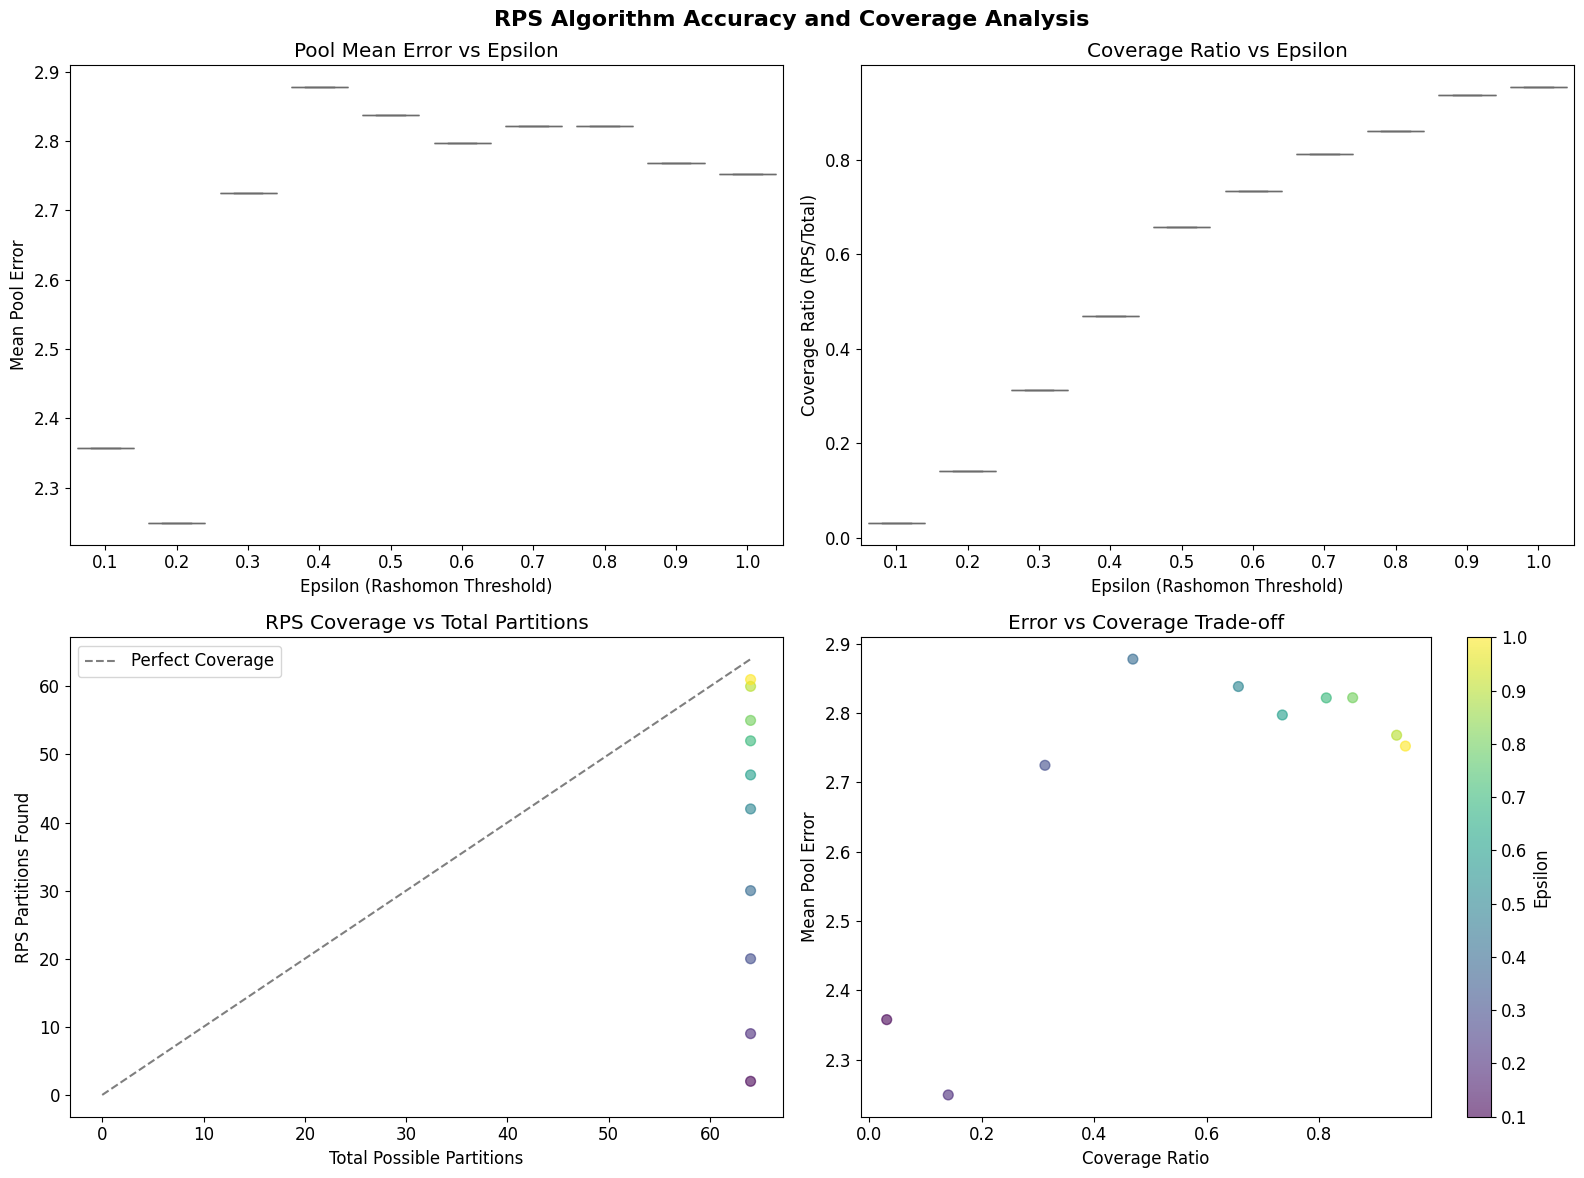

In [20]:
if df is not None:
    # Create a 2x2 subplot for accuracy and coverage analysis
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('RPS Algorithm Accuracy and Coverage Analysis', fontsize=16, fontweight='bold')
    
    # 1. Pool Mean Error vs Epsilon
    ax1 = axes[0, 0]
    sns.boxplot(data=df, x='epsilon', y='rps_posterior_beta_error', ax=ax1)
    ax1.set_xlabel('Epsilon (Rashomon Threshold)')
    ax1.set_ylabel('Mean Pool Error')
    ax1.set_title('Pool Mean Error vs Epsilon')
    
    # 2. Coverage Ratio vs Epsilon
    ax2 = axes[0, 1]
    sns.boxplot(data=df, x='epsilon', y='coverage_ratio', ax=ax2)
    ax2.set_xlabel('Epsilon (Rashomon Threshold)')
    ax2.set_ylabel('Coverage Ratio (RPS/Total)')
    ax2.set_title('Coverage Ratio vs Epsilon')
    
    # 3. RPS Partitions Found vs Total Possible
    ax3 = axes[1, 0]
    max_val = max(df['total_partitions'].max(), df['num_rps_partitions'].max())
    ax3.scatter(df['total_partitions'], df['num_rps_partitions'], 
               c=df['epsilon'], cmap='viridis', alpha=0.6, s=50)
    ax3.plot([0, max_val], [0, max_val], 'k--', alpha=0.5, label='Perfect Coverage')
    ax3.set_xlabel('Total Possible Partitions')
    ax3.set_ylabel('RPS Partitions Found')
    ax3.set_title('RPS Coverage vs Total Partitions')
    ax3.legend()
    
    # 4. Error vs Coverage Trade-off
    ax4 = axes[1, 1]
    scatter = ax4.scatter(df['coverage_ratio'], df['rps_posterior_beta_error'], 
                         c=df['epsilon'], cmap='viridis', alpha=0.6, s=50)
    ax4.set_xlabel('Coverage Ratio')
    ax4.set_ylabel('Mean Pool Error')
    ax4.set_title('Error vs Coverage Trade-off')
    plt.colorbar(scatter, ax=ax4, label='Epsilon')
    
    plt.tight_layout()
    plt.show()

### 5.3 Correlation Analysis

In [ ]:
# if df is not None:
#     # Select numerical columns for correlation analysis
#     corr_columns = ['M', 'R_val', 'H', 'epsilon', 'complexity', 'rps_time', 
#                     'mean_pool_error', 'coverage_ratio', 'num_rps_partitions', 'num_total_partitions']
    
#     # Compute correlation matrix
#     corr_matrix = df[corr_columns].corr()
    
#     # Create correlation heatmap
#     plt.figure(figsize=(12, 10))
#     mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
#     sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='RdBu_r', center=0,
#                 square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
#     plt.title('Correlation Matrix of RPS Performance Metrics', fontsize=14, fontweight='bold')
#     plt.tight_layout()
#     plt.show()
    
#     # Print strongest correlations
#     print("=== STRONGEST CORRELATIONS ===")
#     # Get upper triangle of correlation matrix
#     corr_pairs = []
#     for i in range(len(corr_matrix.columns)):
#         for j in range(i+1, len(corr_matrix.columns)):
#             corr_pairs.append((
#                 corr_matrix.columns[i], 
#                 corr_matrix.columns[j], 
#                 corr_matrix.iloc[i, j]
#             ))
    
#     # Sort by absolute correlation value
#     corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)
    
#     print("Top 10 strongest correlations:")
#     for i, (var1, var2, corr) in enumerate(corr_pairs[:10]):
#         print(f"{i+1:2d}. {var1} ↔ {var2}: {corr:+.3f}")

## 6. Summary and Key Findings

In [ ]:
# if df is not None:
#     print("=== RPS ALGORITHM PERFORMANCE SUMMARY ===")
    
#     # Overall performance metrics
#     total_sims = len(df)
#     unique_param_combos = len(df.groupby(['M', 'R_val', 'H', 'epsilon']))
    
#     print(f"📊 Total Simulations: {total_sims:,}")
#     print(f"🎛️  Parameter Combinations: {unique_param_combos}")
#     print(f"⏱️  Runtime Range: {df['rps_time'].min():.4f}s - {df['rps_time'].max():.2f}s")
#     print(f"🎯 Error Range: {df['mean_pool_error'].min():.4f} - {df['mean_pool_error'].max():.4f}")
#     print(f"📈 Coverage Range: {df['coverage_ratio'].min():.1%} - {df['coverage_ratio'].max():.1%}")
    
#     print("\n=== KEY FINDINGS ===")
    
#     # Runtime scaling
#     runtime_by_complexity = df.groupby('complexity')['rps_time'].mean().sort_index()
#     print(f"🚀 Runtime Scaling: {runtime_by_complexity.iloc[0]:.4f}s (M×R={runtime_by_complexity.index[0]}) → {runtime_by_complexity.iloc[-1]:.2f}s (M×R={runtime_by_complexity.index[-1]})")
    
#     # Best epsilon for accuracy
#     error_by_epsilon = df.groupby('epsilon')['mean_pool_error'].mean()
#     best_epsilon = error_by_epsilon.idxmin()
#     best_error = error_by_epsilon.min()
#     print(f"🎯 Best Accuracy: ε = {best_epsilon} (error = {best_error:.4f})")
    
#     # Best epsilon for coverage  
#     coverage_by_epsilon = df.groupby('epsilon')['coverage_ratio'].mean()
#     best_coverage_epsilon = coverage_by_epsilon.idxmax()
#     best_coverage = coverage_by_epsilon.max()
#     print(f"📈 Best Coverage: ε = {best_coverage_epsilon} (coverage = {best_coverage:.1%})")
    
#     # Runtime vs accuracy trade-off
#     runtime_error_corr = df['rps_time'].corr(df['mean_pool_error'])
#     runtime_coverage_corr = df['rps_time'].corr(df['coverage_ratio'])
#     print(f"⚖️  Runtime-Error Correlation: {runtime_error_corr:+.3f}")
#     print(f"⚖️  Runtime-Coverage Correlation: {runtime_coverage_corr:+.3f}")
    
#     print("\n=== RECOMMENDATIONS ===")
#     print("💡 For fastest runtime: Use smaller M and R values")
#     print("💡 For best accuracy: Consider epsilon values around", best_epsilon)
#     print("💡 For best coverage: Consider epsilon values around", best_coverage_epsilon)
    
#     if abs(runtime_error_corr) > 0.3:
#         print("⚠️  Strong runtime-error correlation detected - consider trade-off analysis")
#     if abs(runtime_coverage_corr) > 0.3:
#         print("⚠️  Strong runtime-coverage correlation detected - consider trade-off analysis")